# Make it a singular function for running on clusters and the like

In [1]:
import sys,os,os.path
sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import os
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import cv2 as cv


from IC.invisible_cities.reco.psf_functions    import create_psf
from IC.invisible_cities.reco.psf_functions    import hdst_psf_processing
from IC.invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from IC.invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import IC.invisible_cities.core.core_functions as     coref
import IC.invisible_cities.io  .dst_io         as     dstio

from IC.invisible_cities.database              import load_db
from IC.invisible_cities.io.dst_io import df_writer

import functions as func

%load_ext autoreload
%autoreload 2

In [2]:
class PSFfactors(tb.IsDescription):
    nevt   = tb. UInt32Col(pos=0)
    xr     = tb.Float32Col(pos=1)
    yr     = tb.Float32Col(pos=2)
    zr     = tb.Float32Col(pos=3)
    x      = tb.Float32Col(pos=4)
    y      = tb.Float32Col(pos=5)
    z      = tb.Float32Col(pos=6)
    factor = tb.Float32Col(pos=7)

def psf_writer(hdf5_file, **kwargs):
    psf_table = make_table(hdf5_file,
                           group       = "PSF",
                           name        = "PSFs",
                           fformat     = PSFfactors,
                           description = "XYZ dependent point spread functions",
                           compression = 'ZLIB4')

    def write_psf(xr, yr, zr, xp, yp, zp, fr, nr):
        row = psf_table.row
        for i, x in enumerate(xr):
            for j, y in enumerate(yr):
                for k, z in enumerate(zr):
                    row["xr"    ] = x
                    row["yr"    ] = y
                    row["zr"    ] = z
                    row["x"     ] = xp
                    row["y"     ] = yp
                    row["z"     ] = zp
                    row["factor"] = fr[i,j,k]
                    row["nevt"  ] = nr[i,j,k]
                    row.append()
    return write_psf

In [3]:
def smooth_psf(psf, kernel_factor = 5):
    #generate kernel
    av_factor = kernel_factor
    kernel    = np.ones((av_factor, av_factor),np.float32)/(av_factor**2)

    finished_psf = []

    # apply across each z slice
    for z, psf_z in psf.groupby('z'):
        # reshape
        nx     = psf_z.xr.unique().size
        ny     = psf_z.yr.unique().size
        matrix = psf_z.factor.values.reshape(nx, ny)
        # smooth
        dst    = cv.filter2D(matrix,-1,kernel)

        # abusing symmetry
        xyrange = (psf_z.xr.min(), psf.xr.max())
        xr_vals = np.linspace(xyrange[0], xyrange[1], nx)
        yr_vals = np.linspace(xyrange[0], xyrange[1], ny)
        
        xr, yr = np.meshgrid(xr_vals, yr_vals, indexing='ij')

        # make a psf dataframe
        psf_smooth = pd.DataFrame({
                                    'xr'     : xr.flatten(),
                                    'yr'     : yr.flatten(),
                                    'zr'     : 0.0,
                                    'x'      : 0.0,
                                    'y'      : 0.0,
                                    'factor' : dst.flatten(),
                                    'z'      : z,
                                    'nevt'   : psf_z['nevt'] # this should map normally?
        })
        finished_psf.append(psf_smooth)
    
    return pd.concat(finished_psf)

In [4]:
psf_data_R15616 = dstio.load_dst('/home/e78368jw/Documents/NEXT_CODE/next_misc/eutricide/psfs/' + '040925_full_25us.psf', 'PSF', 'PSFs')


In [5]:
psf_data_R15616.z.unique()

array([  12.5,   37.5,   62.5,   87.5,  112.5,  137.5,  162.5,  187.5,
        212.5,  237.5,  262.5,  287.5,  312.5,  337.5,  362.5,  387.5,
        412.5,  437.5,  462.5,  487.5,  512.5,  537.5,  562.5,  587.5,
        612.5,  637.5,  662.5,  687.5,  712.5,  737.5,  762.5,  787.5,
        812.5,  837.5,  862.5,  887.5,  912.5,  937.5,  962.5,  987.5,
       1012.5, 1037.5, 1062.5, 1087.5, 1112.5, 1137.5, 1162.5, 1187.5])

87.5


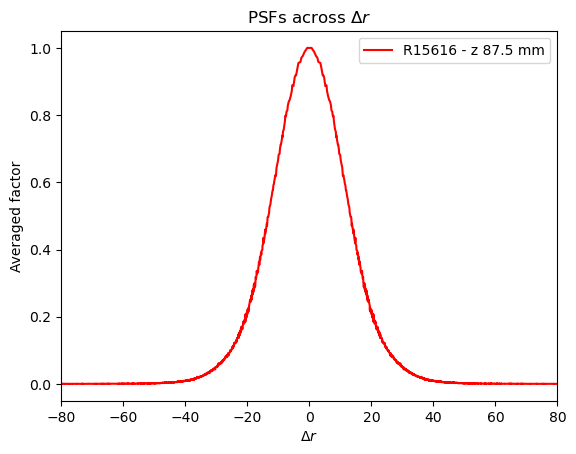

287.5


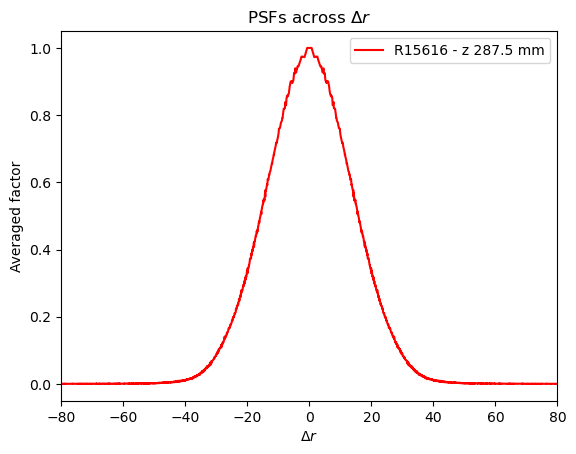

487.5


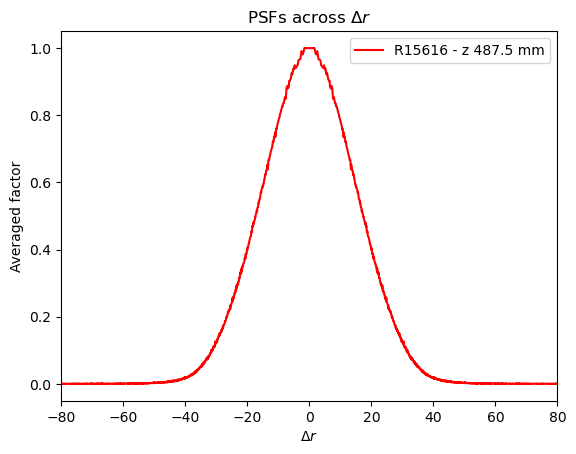

687.5


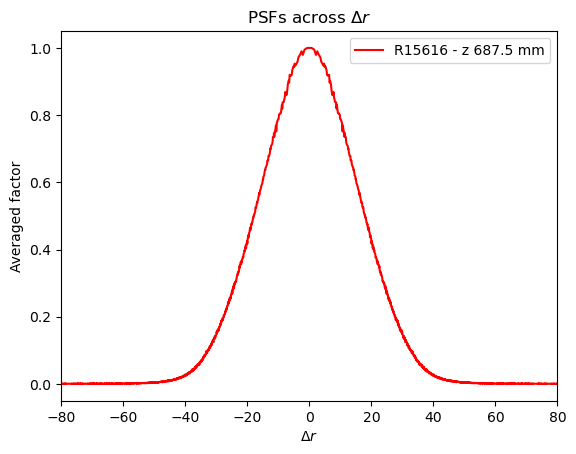

887.5


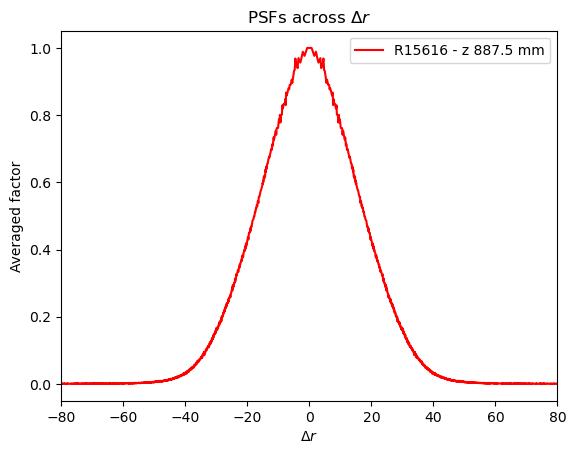

1087.5


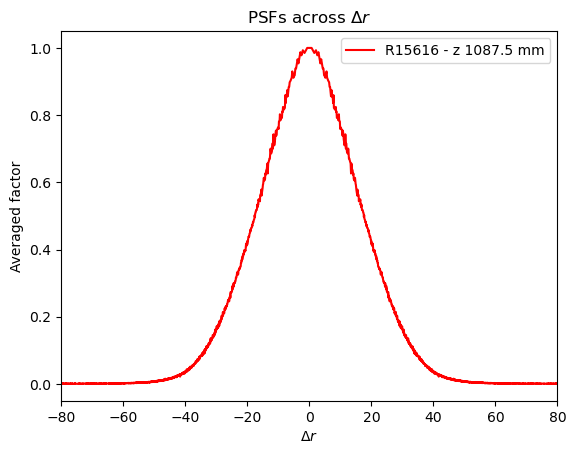

1187.5


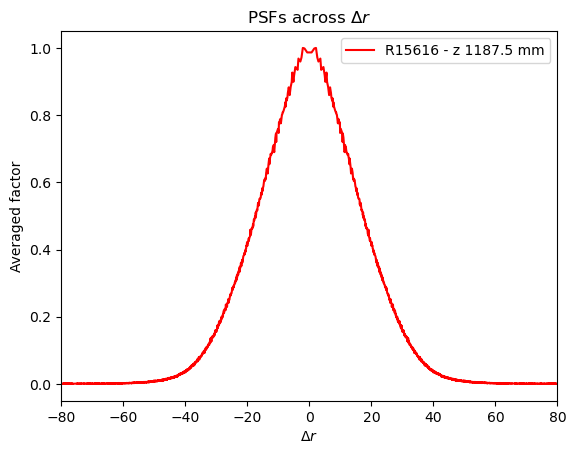

In [6]:
norm = True
for i in [87.5, 287.5, 487.5, 687.5, 887.5, 1087.5, 1187.5]:
    print(i)
    func.create_plots_psf(psf_data_R15616, i, f'R15616 - z {i} mm', norm, color = 'red')
    ## one mm psf
    plt.xlabel("$\Delta r$")
    plt.ylabel("Averaged factor")
    plt.xlim([-80, 80])
    #plt.yscale('log')
    plt.legend()
    plt.title("PSFs across $\Delta r$")
    plt.show()

In [7]:
psf_data_R15616.xr.diff().unique()[-1]

1.0

In [8]:
output_file = 'psfs/smoother_R15616.psf'

# smooth it!
bin_size_xy = psf_data_R15616.xr.diff().unique()[-1]
R15616_smooth = smooth_psf(psf_data_R15616)
with tb.open_file(output_file, 'w') as h5out:
    df_writer(h5out, R15616_smooth, 
              'PSF', 'PSFs',
              descriptive_string = f"PSF with {bin_size_xy} mm bin size")

In [9]:
display(psf_data_R15616)
display(R15616_smooth)

,xr,yr,zr,x,y,z,factor,nevt
0,-99.5,-99.5,0.0,0.0,0.0,12.5,0.000000,8
1,-99.5,-99.5,0.0,0.0,0.0,37.5,0.000000,62
2,-99.5,-99.5,0.0,0.0,0.0,62.5,0.000000,51
3,-99.5,-99.5,0.0,0.0,0.0,87.5,0.000000,80
4,-99.5,-99.5,0.0,0.0,0.0,112.5,0.000000,87
...,...,...,...,...,...,...,...,...
1919995,99.5,99.5,0.0,0.0,0.0,1087.5,0.000000,161
1919996,99.5,99.5,0.0,0.0,0.0,1112.5,0.000063,175
1919997,99.5,99.5,0.0,0.0,0.0,1137.5,0.000105,167
1919998,99.5,99.5,0.0,0.0,0.0,1162.5,0.000000,145


,xr,yr,zr,x,y,factor,z,nevt
0,-99.5,-99.5,0.0,0.0,0.0,0.000000,12.5,8
48,-99.5,-98.5,0.0,0.0,0.0,0.000000,12.5,7
96,-99.5,-97.5,0.0,0.0,0.0,0.000000,12.5,9
144,-99.5,-96.5,0.0,0.0,0.0,0.000000,12.5,8
192,-99.5,-95.5,0.0,0.0,0.0,0.000000,12.5,6
...,...,...,...,...,...,...,...,...
1919807,99.5,95.5,0.0,0.0,0.0,0.000027,1187.5,143
1919855,99.5,96.5,0.0,0.0,0.0,0.000032,1187.5,168
1919903,99.5,97.5,0.0,0.0,0.0,0.000032,1187.5,173
1919951,99.5,98.5,0.0,0.0,0.0,0.000039,1187.5,146


87.5


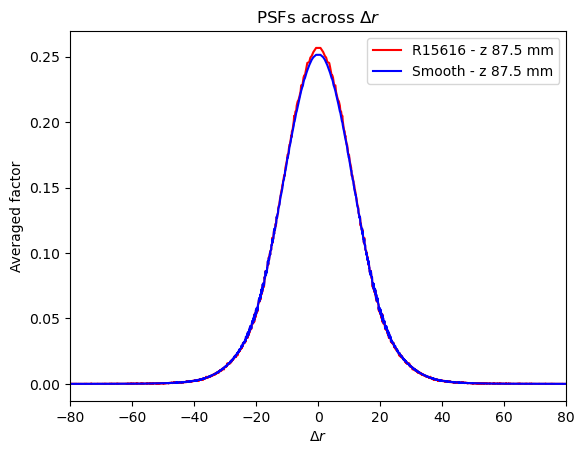

287.5


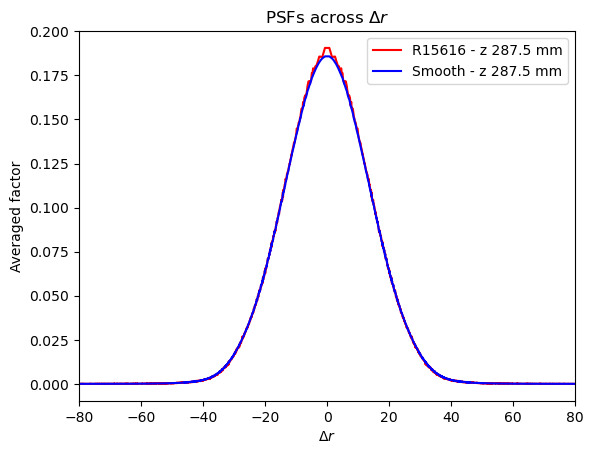

487.5


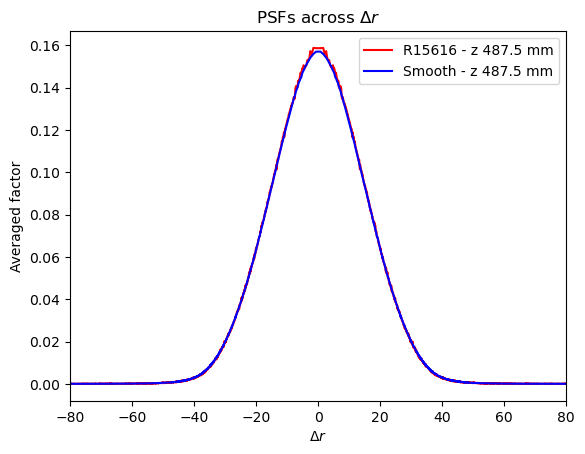

687.5


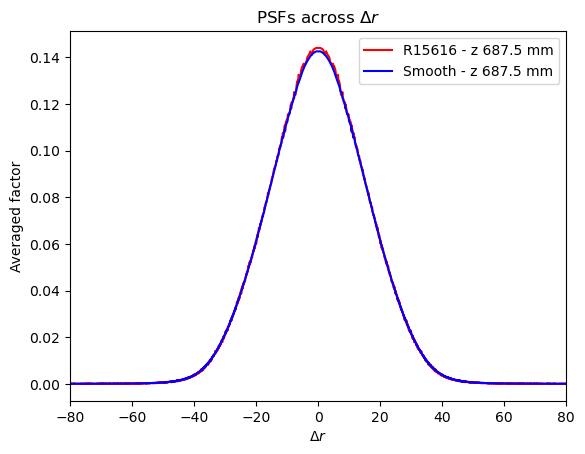

887.5


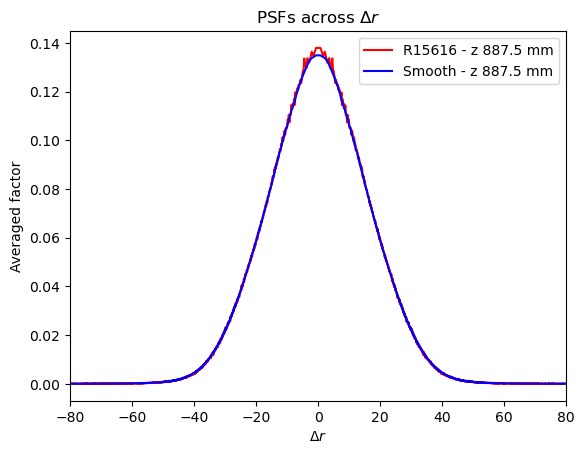

1087.5


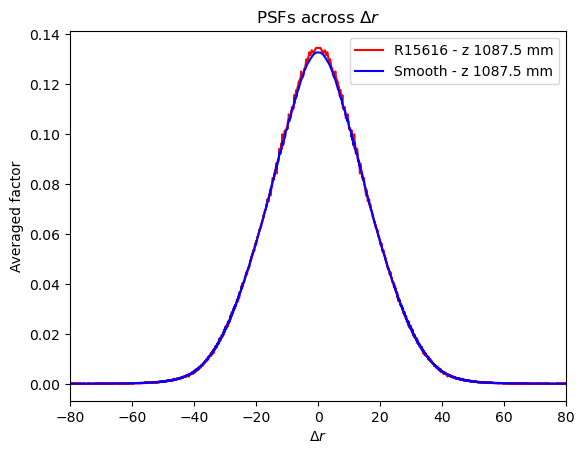

In [12]:
norm = False
for i in [87.5, 287.5, 487.5, 687.5, 887.5, 1087.5]:
    print(i)
    func.create_plots_psf(psf_data_R15616, i, f'R15616 - z {i} mm', norm, color = 'red')
    func.create_plots_psf(R15616_smooth, i, f'Smooth - z {i} mm', norm, color = 'blue')
    ## one mm psf
    plt.xlabel("$\Delta r$")
    plt.ylabel("Averaged factor")
    plt.xlim([-80, 80])
    #plt.yscale('log')
    plt.legend()
    plt.title("PSFs across $\Delta r$")
    #plt.yscale('log')
    plt.show()

87.5
287.5
487.5
887.5
1087.5


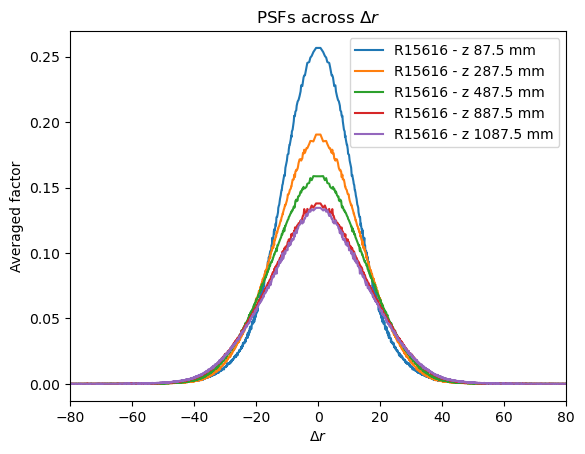

In [18]:
norm = False
for i in [87.5, 287.5, 487.5, 887.5, 1087.5]:
    print(i)
    func.create_plots_psf(psf_data_R15616, i, f'R15616 - z {i} mm', norm)#, color = 'red')
    #func.create_plots_psf(R15616_smooth, i, f'Smooth - z {i} mm', norm)#, color = 'blue')
    ## one mm psf
    plt.xlabel("$\Delta r$")
    plt.ylabel("Averaged factor")
    plt.xlim([-80, 80])
    #plt.yscale('log')
    plt.legend()
    plt.title("PSFs across $\Delta r$")
    #plt.yscale('log')
plt.show()